In [1]:
import pandas as pd
import numpy as np

In [2]:
file = 'supermarket_sales.csv'
columns = ['Branch', 'Product line', 'Payment', 'Total']

In [1]:
#Import required libraries
import pandas as pd
import numpy as np

#Select datafile to import and columns to analyse
file = 'supermarket_sales.csv'
columns = ['Branch', 'Product line', 'Payment', 'Total']

#Import PowerBI data into DataFrame, select columns and remove spaces from column headers
#Dependent variable should be the last column in the file or in the column selection
#Normalization of the data is optional but enabled by default
def import_data(file, *args, normalize=True):
    data = pd.read_csv(file)
    df = pd.DataFrame(data)
    columns = list(*args) #Create a list of selected columns
    df = df[columns]
    df.columns = df.columns.str.replace(' ', '') #Remove spaces from column names
    if len(df.columns) == 0:
        print('Please enter columns to be considered') #Give a warning if no colomns are selected
    else:
        #Optionally normalize the data
        print(f'Normalize = {normalize} (set to "normalize=False" to disable normalization)')
        #Returns the log value of the 'Total' column as output
        def normalize_data(df):
            df['Total'] = np.log(df['Total'])
            return df
        if normalize == True:
            normalize_data(df)
        return df

#Computes the expected values for the 'Total' column in the DataFrame, by the use of a main-effects ANOVA
#Input is a DataFrame with a 'Total' column as last column
#Output is a DataFrame with an added column named 'Expectedvalue'
def compute_expected_values(df):
    dimension_means = {}
    x = list(df.columns[:-1]) #List all column names, excluding the 'Total' column
    y = df.groupby(x)[df.columns[-1]].mean() #Creating a series of every combination of the selected columns and calculating the mean value of 'Total' per combination
    for item in range(0, len(y)):
        dimension_means[y.index[item]] = y.values[item] #Save all groupings and their respective means in a dictionary as a key, value pair
    z = []
    for item in range(0, len(df)):
        z.append(df.values[item][0:(len(df.columns) - 1)]) #For each row in the data, list the combination of column headers for that particular row
    #Correcting trailing ',' for single tuple values in 1 dimensional data, which is added by default
    if len(x) == 1:
        z = ([x[0] for x in z])
    df['Expectedvalue'] = tuple(z) #Make a new column in the DataFrame that contains a tuple of the respective combination of column headers for every row in the DataFrame
    df['Expectedvalue'] = df['Expectedvalue'].map(dimension_means) #Map the respective mean values from the earlier created dictionary on the combination of column headers to create a column containing 'Expected Values'
    return df

#Computes the InExp value for a DataFrame by calculating main effects of all separate dimensions compared to the 'Expectedvalue'
#Input is a DataFrame containing columns named 'Total' and 'Expectedvalue'
#Output is a new column named InExp, which is the max of the main effects of separate dimensions and 'Expectedvalue'
def compute_InExp(df):
    #Disable SettingWithCopyWarning for chained assignment, wich is a redundant error warning that does not apply here
    pd.options.mode.chained_assignment = None
    #Calculate alt_means for separate dimensions
    alt_means = {}
    x = list(df.columns[:-1])
    for item in x[:-1]:
        y = df.groupby(item)[df.columns[-1]].mean() #Create a series of every individual dimension and calculate the mean value of 'Total' per dimension
        for item in range(0, len(y)):
            alt_means[y.index[item]] = y.values[item] #Save every dimension and their respective mean in a dictionary as a key, value pair
    #Create new DataFrame for comparison of dimension means and return InExp as max
    z = list(df.columns[:-2]) #List column names
    dfInx = df[z]
    for item in z:
        dfInx[item] = dfInx[item].map(alt_means) #Add a new column to the DataFrame for every dimension in the original data and map the values from the dictionary to each row in the respective columns
    dfInx['SelfExp'] = df['Expectedvalue'].astype(float) #Add the 'Expectedvalue' from the original DataFrame to this new DataFrame
    dfInx['InExp'] = dfInx.max(axis=1) #Select the max value from each row to determine the 'InExp' value
    df['InExp'] = dfInx['InExp'] #Add the 'InExp' column to the original DataFrame
    return df

#Computes residual values by subtracting the 'Expectedvalue' from the 'Total' and dividing this by the standard deviation of the data
#Input is a DataFrame containing 'Total' and 'Expectedvalue' columns
#Output is a DataFrame with an added column 'Residuals'
def compute_residual_values(df):
    #Calculate standard deviation
    v = sum((df['Total'] - df['Total'].mean())**2) / (len(df) - 1)
    sd = v**(0.5)
    try:
        df['Residual'] = df['Total'] - df['InExp'] / sd
    except Exception:
        df['Residual'] = df['Total'] - df['Expectedvalue'] / sd
    return df  

#Identifies exceptional values according to a certain threshold - default threshold value is 2.576 or p=.99
#Input is a DataFrame containing a column called 'Residual' containing residual values and optionally a threshold value
#Output is a dictionary of exceptions that contains the indices of exceptional values
def identify_exceptional_values(df, threshold):
    print(f'Threshold = {threshold} (default: p=.99) (set to "threshold=x" to alter threshold value to x)')
    #Create lists of high and low residual values
    high = df.index[df['Residual'] > threshold].tolist()
    low = df.index[df['Residual'] < - threshold].tolist()
    exceptions = {'high': high, 'low': low} 
    print(f'Marked {len(high)} high and {len(low)} low exceptional values with a threshold of {threshold}.')
    return exceptions

#Adds a color scheme to the original DataFrame by marking low exceptions in red and high exceptions in green
#Input is a list containing indices of exceptional values
#Output is a 'Styler' component which is a DataFrame plus style components rendered as HTML
def mark_exceptional_values(x):
    color_high = 'background-color: lightgreen'
    color_low = 'background-color: pink'
    dfmarked = pd.DataFrame('', index=x.index, columns=x.columns)
    #Create a temporary DataFrame in which the rows of exceptional values are marked
    dfmarked.iloc[exceptions['high']] = color_high
    dfmarked.iloc[exceptions['low']] = color_low
    return dfmarked

#Aggregrates all functions in one main function that can be called
#Input is optionally a different threshold value
#Output is a styler component, which is an HTML render of a pandas DataFrame
def main(threshold=2.576):
    result = import_data(file, columns)
    result = compute_expected_values(result)
    result = compute_InExp(result)
    result = compute_residual_values(result)
    global exceptions
    exceptions = identify_exceptional_values(result, threshold)
    result = result.style.apply(mark_exceptional_values, axis=None)
    return display(result)
    
#Execute function
if __name__ == '__main__':
    main()

Normalize = True (set to "normalize=False" to disable normalization)
Threshold = 2.576 (default: p=.99) (set to "threshold=x" to alter threshold value to x)
Marked 0 high and 24 low exceptional values with a threshold of 2.576.


Normalize = True (set to "normalize=False" to disable normalization)
Threshold = 2.576 (default: p=.99) (set to "threshold=x" to alter threshold value to x)
Found 24 exceptional values with a threshold of 2.576.
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


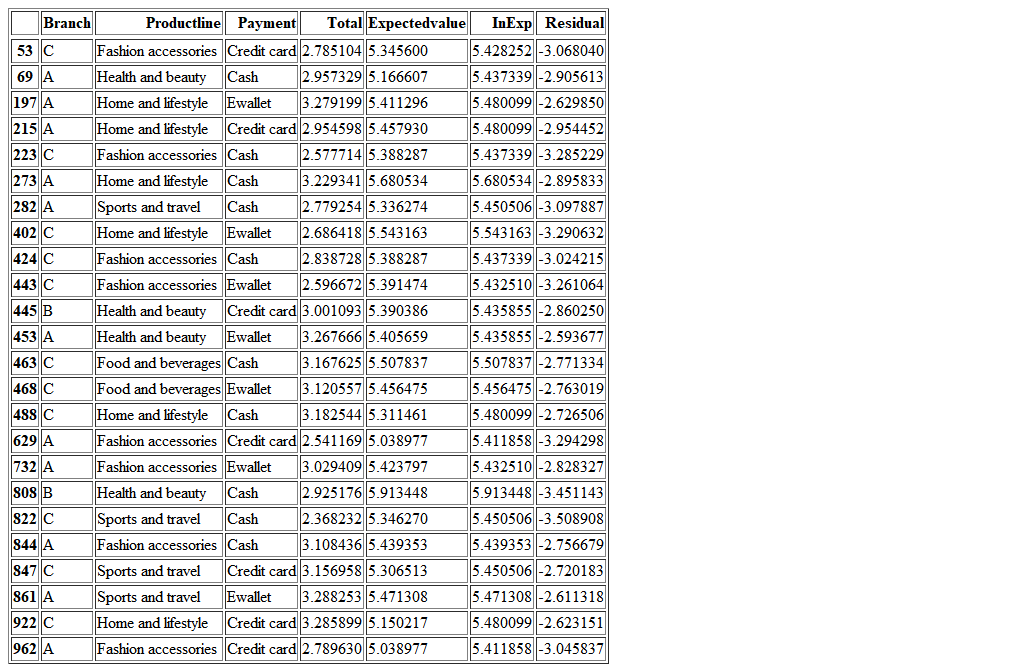

In [12]:
#Import required libraries
import pandas as pd
import numpy as np

#Select datafile to import and columns to analyse
file = 'supermarket_sales.csv'
columns = ['Branch', 'Product line', 'Payment', 'Total']

#Import PowerBI data into DataFrame, select columns and remove spaces from column headers
#Dependent variable should be the last column in the file or in the column selection
#Normalization of the data is optional but enabled by default
def import_data(file, *args, normalize=True):
    data = pd.read_csv(file)
    df = pd.DataFrame(data)
    columns = list(*args) #Create a list of selected columns
    df = df[columns]
    df.columns = df.columns.str.replace(' ', '') #Remove spaces from column names
    if len(df.columns) == 0:
        print('Please enter columns to be considered') #Give a warning if no colomns are selected
    else:
        #Optionally normalize the data
        print(f'Normalize = {normalize} (set to "normalize=False" to disable normalization)')
        #Returns the log value of the 'Total' column as output
        def normalize_data(df):
            df['Total'] = np.log(df['Total'])
            return df
        if normalize == True:
            normalize_data(df)
        return df

#Computes the expected values for the 'Total' column in the DataFrame, by the use of a main-effects ANOVA
#Input is a DataFrame with a 'Total' column as last column
#Output is a DataFrame with an added column named 'Expectedvalue'
def compute_expected_values(df):
    dimension_means = {}
    x = list(df.columns[:-1]) #List all column names, excluding the 'Total' column
    y = df.groupby(x)[df.columns[-1]].mean() #Creating a series of every combination of the selected columns and calculating the mean value of 'Total' per combination
    for item in range(0, len(y)):
        dimension_means[y.index[item]] = y.values[item] #Save all groupings and their respective means in a dictionary as a key, value pair
    z = []
    for item in range(0, len(df)):
        z.append(df.values[item][0:(len(df.columns) - 1)]) #For each row in the data, list the combination of column headers for that particular row
    #Correcting trailing ',' for single tuple values in 1 dimensional data, which is added by default
    if len(x) == 1:
        z = ([x[0] for x in z])
    df['Expectedvalue'] = tuple(z) #Make a new column in the DataFrame that contains a tuple of the respective combination of column headers for every row in the DataFrame
    df['Expectedvalue'] = df['Expectedvalue'].map(dimension_means) #Map the respective mean values from the earlier created dictionary on the combination of column headers to create a column containing 'Expected Values'
    return df

#Computes the InExp value for a DataFrame by calculating main effects of all separate dimensions compared to the 'Expectedvalue'
#Input is a DataFrame containing columns named 'Total' and 'Expectedvalue'
#Output is a new column named InExp, which is the max of the main effects of separate dimensions and 'Expectedvalue'
def compute_InExp(df):
    #Disable SettingWithCopyWarning for chained assignment, wich is a redundant error warning that does not apply here
    pd.options.mode.chained_assignment = None
    #Calculate alt_means for separate dimensions
    alt_means = {}
    x = list(df.columns[:-1])
    for item in x[:-1]:
        y = df.groupby(item)[df.columns[-1]].mean() #Create a series of every individual dimension and calculate the mean value of 'Total' per dimension
        for item in range(0, len(y)):
            alt_means[y.index[item]] = y.values[item] #Save every dimension and their respective mean in a dictionary as a key, value pair
    #Create new DataFrame for comparison of dimension means and return InExp as max
    z = list(df.columns[:-2]) #List column names
    dfInx = df[z]
    for item in z:
        dfInx[item] = dfInx[item].map(alt_means) #Add a new column to the DataFrame for every dimension in the original data and map the values from the dictionary to each row in the respective columns
    dfInx['SelfExp'] = df['Expectedvalue'].astype(float) #Add the 'Expectedvalue' from the original DataFrame to this new DataFrame
    dfInx['InExp'] = dfInx.max(axis=1) #Select the max value from each row to determine the 'InExp' value
    df['InExp'] = dfInx['InExp'] #Add the 'InExp' column to the original DataFrame
    return df

#Computes residual values by subtracting the 'Expectedvalue' from the 'Total' and dividing this by the standard deviation of the data
#Input is a DataFrame containing 'Total' and 'Expectedvalue' columns
#Output is a DataFrame with an added column 'Residuals'
def compute_residual_values(df):
    #Calculate standard deviation
    v = sum((df['Total'] - df['Total'].mean())**2) / (len(df) - 1)
    sd = v**(0.5)
    try:
        df['Residual'] = df['Total'] - df['InExp'] / sd
    except Exception:
        df['Residual'] = df['Total'] - df['Expectedvalue'] / sd
    return df  

#Identifies exceptional values according to a certain threshold - default threshold value is 2.576 or p=.99
#Input is a DataFrame containing a column called 'Residual' containing residual values and optionally a threshold value
#Output is a DataFrame containing all the exceptional values and their indices
def identify_exceptional_values(df, threshold):
    print(f'Threshold = {threshold} (default: p=.99) (set to "threshold=x" to alter threshold value to x)')
    df = df[(df.Residual > threshold) | (df.Residual < -threshold)] #Select DataFrame rows on index
    print(f'Found {len(df)} exceptional values with a threshold of {threshold}.')
    return df

#Aggregrates all functions in one main function that can be called
#Input is optionally a different threshold value
#Output is an HTML render of a pandas DataFrame, containing all rows of interest
def main(threshold=2.576):
    result = import_data(file, columns)
    result = compute_expected_values(result)
    result = compute_InExp(result)
    result = compute_residual_values(result)
    result = identify_exceptional_values(result, threshold)
    
    html = result.to_html()#Render DataFrame as HTML

    import imgkit
    from IPython.display import Image
    imgkit.from_string(html, 'styled_table.png') #convert HTML to PNG
    return display(Image("styled_table.png"))
    
#Execute function
if __name__ == '__main__':
    main()

In [2]:
#Append to main to render png
    global html
    html = result.render()
    return html

import imgkit
imgkit.from_string(html, 'styled_table.png')
from IPython.display import Image
Image("styled_table.png")

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [3]:
styled_table.png

NameError: name 'styled_table' is not defined

In [2]:
if __name__ == '__main__':
    main()

Normalize = True (set to "normalize=False" to disable normalization)
Threshold = 2.576 (default: p=.99) (set to "threshold=x" to alter threshold value to x)
Marked 0 high and 24 low exceptional values with a threshold of 2.576.


In [3]:
#class structure
#class find_exceptional_values:

#    def __init__(self, file, *columns):
#        self.file = file
#        self.columns = columns

    #def main():
    #    df = find_exceptional_values.import_data(file, columns)
    #    df = find_exceptional_values.compute_expected_values(df)
    #    df = find_exceptional_values.compute_residual_values(df)
    #    exceptions = find_exceptional_values.identify_exceptional_values(df)
    #    df = df.style.apply(find_exceptional_values.mark_exceptional_values(), axis=None)

#if __name__ == '__main__':
    #main()

In [6]:
def find_exceptional_values(data, threshold=1.645, normalize=True):

    print(f'Threshold = {threshold} (p=.95) (set to "threshold=x" to alter threshold value to x)')
    print(f'Normalize = {normalize} (set to "normalize=False" to disable normalization)')
    
    #Set global variables for diagnostics
    global dfM
    global dfE
    dfM = len(data.columns) - 2
    dfE = len(data.values) - (dfM + 1)
    
    def normalize_data(data):
        data['Total'] = np.log(data['Total'])
        return(data)

    def identify_exceptional_values(data):
        def standard_deviation(data):
            data['Variance'] = (data['Total'] - data['Total'].mean())**2
            x = data['Variance'].sum() / (len(data) - 1)
            sd = x**(0.5)
            del data['Variance']
            #Set global variables for diagnostics
            global SST
            SST = sd**2*len(data)
            return (sd)

        #Calculate all main effects and set expected value as column
        def calculate_expected_value(data):
            dimension_means = {}
            x = list(data.columns)
            x.remove('Total')
            y = data.groupby(x)['Total'].mean()
            for item in range(0, len(y)):
                dimension_means[y.index[item]] = y.values[item]
            x = []
            for item in range(0,len(data)):
                x.append(data.values[item][0:(len(data.columns) - 1)])
            data['Expectedvalue'] = tuple(x)
            data['Expectedvalue'] = data['Expectedvalue'].map(dimension_means)
            return(data)

        #Create residual column for scaled residuals
        def calculate_residuals(data):
            data['Residual'] = data['Total'] - data ['Expectedvalue']
            data['Residual'] = (data['Residual'] / standard_deviation(data))
            return(data)

        def exception_identification(data):
            high = data.index[data['Residual'] > threshold].tolist()
            low = data.index[data['Residual'] < - threshold].tolist()
            exception = {'high': high, 'low': low}
            return(exception)

        calculate_expected_value(data)
        calculate_residuals(data)
        
        #Calculate SSE for diagnostics
        data['Residual2'] = data['Residual']**2
        global SSE
        SSE = data['Residual2'].sum()
        
        result = exception_identification(data)
        del data['Expectedvalue']
        del data['Residual']
        del data['Residual2']

        return(result)

    def mark_exceptional_values(x):
        identify_exceptional_values(data)
        color1 = 'background-color: green'
        color2 = 'background-color: red'
        high = identify_exceptional_values(data)['high']
        low = identify_exceptional_values(data)['low']
        df1 = pd.DataFrame('', index=x.index, columns=x.columns)
        for item in high:
            df1.iloc[item, (x.columns.get_loc('Total'))] = color1
        for item in low:
            df1.iloc[item, (x.columns.get_loc('Total'))] = color2
        
        #run_diagnostics(x):
        #R2, F (Quality of model)
        SSR = SST - SSE
        R2 = 1 - SSR/SST
        F = (SSR/dfM)/(SSE/dfE)
        print(f'R2 = {R2}')
        print(f'F = {F}')
        
        from scipy import stats
        #Tukey's range test (Independence)

        #Shapiro-Wilk test (Normality)
        alpha = 0.05
        stat, p = stats.shapiro(data['Total'])
        print(f'ShapiroResult(statistic={stat}, pvalue={p})')
        #if p > alpha:
        #    print(f'Sample looks Gaussian (fail to reject H0) (p={p})')
        #else:
        #    print(f'Sample does not look Gaussian (reject H0) (p={p})')

        #Bartlett's test (Homoscedasticity)
        x = list(data.columns)
        x.remove('Total')
        y = dict(data.groupby(x)['Total'].apply(list))
        list_y = [v for v in y.values()]
        print(stats.bartlett(*list_y))
        
        print(f'Marked {len(high)} high and {len(low)} low exceptional values with a threshold of {threshold}.')
        return df1
       
    if normalize == True:
        normalize_data(data)
        return data.style.apply(mark_exceptional_values, axis=None)
    else:
        return data.style.apply(mark_exceptional_values, axis=None)

In [20]:
find_exceptional_values(data)

Threshold = 1.645 (p=.95) (set to "threshold=x" to alter threshold value to x)
Normalize = True (set to "normalize=False" to disable normalization)
R2 = 1.151953102855826
F = -131.6452868386381
ShapiroResult(statistic=0.9658159613609314, pvalue=1.4286428688821927e-14)
BartlettResult(statistic=27.41944753541879, pvalue=0.0521960116366941)
Marked 5 high and 64 low exceptional values with a threshold of 1.645.


In [43]:
#from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
# Set up the data for comparison (creates a specialised object)
#MultiComp = MultiComparison(data.groupby('Branch')['Total'].apply(list), data.groupby('Payment')['Total'].apply(list))

# Show all pair-wise comparisons:

# Print the comparisons

#print(MultiComp.tukeyhsd().summary())

In [221]:
find_exceptional_values(data, normalize=False)

Threshold = 1.645 (p=.95), set to "threshold=x" to alter threshold value to x.
Normalize = False, set to "normalize=False" to disable normalization.
R2 = 1.136427009946749
F = -59.84446327234093
Marked 3 high and 64 low exceptional values with a threshold of 1.645.
